In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
import torchvision.models as models
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_dir = "/content/drive/MyDrive/ThiGiacMay/btl/char_bien_so"

In [4]:
# Hàm tiền xử lý ảnh: đổi ảnh thành grayscale và chuẩn hóa
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (32, 32))  # Đổi kích thước ảnh
    img = img / 255.0  # Chuẩn hóa giá trị pixel
    if len(img.shape) == 2:  # Nếu ảnh là 2 chiều (height, width)
        img = np.expand_dims(img, axis=0)
    return img

In [5]:
img_path = "/content/drive/MyDrive/ThiGiacMay/btl/char_bien_so/0/1345_2.jpg"
img_test = cv2.imread("/content/drive/MyDrive/ThiGiacMay/btl/char_bien_so/0/1345_2.jpg")
cv2_imshow(img_test)

In [6]:
img_test.shape

(28, 12, 3)

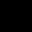

[[[0.00392157 0.01568627 0.08627451 ... 0.00392157 0.00784314 0.00784314]
  [0.1254902  0.13333333 0.19215686 ... 0.         0.         0.        ]
  [0.14117647 0.15294118 0.21176471 ... 0.00392157 0.00392157 0.00392157]
  ...
  [0.00392157 0.00392157 0.         ... 0.2745098  0.25098039 0.24705882]
  [0.         0.         0.         ... 0.19215686 0.14509804 0.1372549 ]
  [0.         0.         0.00784314 ... 0.05098039 0.00784314 0.        ]]]


In [7]:
x = preprocess_image(img_path)
cv2_imshow(x.squeeze(0))
print(np.array(x))

In [8]:
x.shape

(1, 32, 32)

In [9]:
# Hàm chuẩn bị dữ liệu
def prepare_data(data_dir):
    images = []
    labels = []
    label_dict = {}  # Lưu nhãn tương ứng với các thư mục
    label_id = 0  # Khởi tạo nhãn bắt đầu từ 0

    # Đọc ảnh từ các thư mục trong bộ dữ liệu
    for folder in sorted(os.listdir(data_dir)):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            label_dict[label_id] = folder  # Gán nhãn cho từng thư mục
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                img = preprocess_image(image_path)
                images.append(img)
                labels.append(label_id)
            label_id += 1  # Tăng nhãn cho thư mục tiếp theo

    # Chuyển danh sách ảnh và nhãn thành numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_dict

In [10]:
# Chuẩn bị dữ liệu
images, labels, label_dict = prepare_data(data_dir)

In [11]:
# In ra thông tin về dữ liệu
print("Total number of images:", len(images))
print("Label Dictionary:", label_dict)
# thiếu I, J, O, W, Q

Total number of images: 3100
Label Dictionary: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'K', 19: 'L', 20: 'M', 21: 'N', 22: 'P', 23: 'R', 24: 'S', 25: 'T', 26: 'U', 27: 'V', 28: 'X', 29: 'Y', 30: 'Z'}


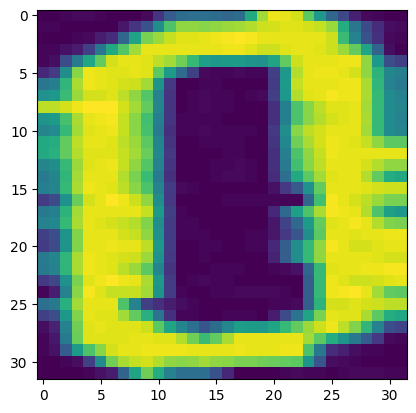

Label: 0


In [12]:
import matplotlib.pyplot as plt

image = images[0]
label = labels[0]
image_to_show = image.squeeze(0)
plt.imshow(image_to_show)  # hoặc image[0]
plt.show()

# In ra nhãn
print("Label:", label_dict[label.item()])

In [13]:
from sklearn.model_selection import train_test_split
# Chia dữ liệu thành 80% train và 20% test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [14]:
# Chuyển đổi dữ liệu sang Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Nhãn kiểu long (int64)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [15]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [16]:
from torch.utils.data import DataLoader

# Tạo Dataset cho dữ liệu huấn luyện và kiểm tra
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

# Tạo DataLoader cho dữ liệu huấn luyện và kiểm tra
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
import torch.nn.functional as F

class TinyCNN(nn.Module):
    def __init__(self, num_classes):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
num_classes = len(label_dict)
model = TinyCNN(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
epochs = 10
for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%')

Epoch [1/10], Loss: 236.0607, Accuracy: 14.96%
Epoch [2/10], Loss: 50.2200, Accuracy: 82.10%
Epoch [3/10], Loss: 19.6772, Accuracy: 93.55%
Epoch [4/10], Loss: 12.4243, Accuracy: 95.36%
Epoch [5/10], Loss: 9.6490, Accuracy: 96.01%
Epoch [6/10], Loss: 8.7886, Accuracy: 96.69%
Epoch [7/10], Loss: 8.1684, Accuracy: 96.77%
Epoch [8/10], Loss: 6.2313, Accuracy: 97.38%
Epoch [9/10], Loss: 6.1782, Accuracy: 97.46%
Epoch [10/10], Loss: 5.8836, Accuracy: 97.74%


In [20]:
# Hàm tính độ chính xác trên tập validation hoặc test
def evaluate_accuracy(model, data_loader):
    model.eval()  # Chuyển mô hình về chế độ đánh giá (không cập nhật trọng số)
    correct = 0
    total = 0
    with torch.no_grad():  # Tắt tính toán gradient để tiết kiệm bộ nhớ
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Dự đoán lớp có xác suất cao nhất
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Tính số lượng đúng
    accuracy = 100 * correct / total
    return accuracy

# Tính độ chính xác trên tập kiểm tra (test_loader)
accuracy = evaluate_accuracy(model, test_loader)
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 97.10%


In [25]:
import time
def predict_image(model, image):
    model.eval()  # Chuyển mô hình về chế độ đánh giá
    image = torch.tensor(image, dtype=torch.float32)  # Chuyển thành tensor
    with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ
        output = model(image)
        _, predicted = torch.max(output, 1)  # Lấy lớp có xác suất cao nhất
    return predicted.item()  # Trả về nhãn dự đoán


path = "/content/Screenshot 2025-04-06 142736.png"
start_time = time.time()
img = preprocess_image(path)
# Dự đoán cho ảnh đầu tiên trong batch
predicted_label = predict_image(model, img)
end_time = time.time()
print(f"Predicted time: {end_time-start_time}")
print(f'Predicted label: {label_dict[predicted_label]}')

Predicted time: 0.0031402111053466797
Predicted label: 5


# Lưu mô hình

In [27]:
# Lưu toàn bộ mô hình (cấu trúc và trọng số)
torch.save(model, "tinycnn_full_model.pth")

# Để tải lại mô hình:
model_load = torch.load("tinycnn_full_model.pth", weights_only=False)
model_load.eval()  # Đặt mô hình vào chế độ đánh giá

TinyCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=31, bias=True)
)

In [29]:
import time
def predict_image(model, image):
    model.eval()  # Chuyển mô hình về chế độ đánh giá
    image = torch.tensor(image, dtype=torch.float32)  # Chuyển thành tensor
    with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ
        output = model(image)
        _, predicted = torch.max(output, 1)  # Lấy lớp có xác suất cao nhất
    return predicted.item()  # Trả về nhãn dự đoán


path = "/content/Screenshot 2025-04-06 142736.png"
start_time = time.time()
img = preprocess_image(path)
# Dự đoán cho ảnh đầu tiên trong batch
predicted_label = predict_image(model_load, img)
end_time = time.time()
print(f"Predicted time: {end_time-start_time}")
print(f'Predicted label: {label_dict[predicted_label]}')

Predicted time: 0.0052258968353271484
Predicted label: 5


In [30]:
from google.colab import files
files.download('tinycnn_full_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>